In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [ ]:
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [ ]:
%matplotlib inline
#!gdown https://drive.google.com/uc?id=1qq758Tjsfm7Euu9ev7hSyLkMj63YC9ST  #dog breed classification dataset
#!gdown https://drive.google.com/uc?id=1dFnDCOxws2uX4ZpauSPC6r6jdjHoJw_p  #pre-trained model
#!unzip --qq dogs_classification.zip


In [ ]:
# libraries
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense,GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications.resnet50 import preprocess_input
import matplotlib.pyplot as plt
from glob import glob
import tensorflow as tf
from keras.applications.resnet50 import ResNet50
from keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Model

In [ ]:
train_path = "/content/gdrive/MyDrive/Kaggle/dogs_classification/imgs/"
test_path = "/content/gdrive/MyDrive/Kaggle/dogs_classification/imgs_validation/"

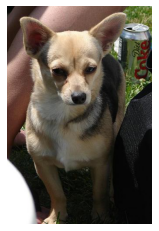

In [ ]:
img = load_img(train_path + "n02085620-Chihuahua/n02085620_10074.jpg")
plt.imshow(img)
# matristeki x ,y axisleri kaldırdık
plt.axis("off")
plt.show()


In [ ]:
# class sayısını almak için yaptık trainpath içine gir /* ==> hepsini al
className = glob(train_path + '/*' )
numberOfClass = len(className)
print("NumberOfClass: ",numberOfClass)

NumberOfClass:  120


In [ ]:
img_height,img_widght=(224,224)
batch_size = 128

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   validation_split=0.2,
                   shear_range = 0.3,
                   horizontal_flip=True,
                   zoom_range = 0.4)


# test verilerini normalize ettik 
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)



validation_generator= train_datagen.flow_from_directory(
        train_path, 
        target_size=(img_height,img_widght),
        batch_size = batch_size,
        color_mode='rgb',
        class_mode= "categorical",
        subset="validation")

train_generator = train_datagen.flow_from_directory(
        train_path, 
        target_size=(img_height,img_widght),
        batch_size = batch_size,
        color_mode='rgb',
        class_mode= "categorical",
        subset="training")

test_generator = test_datagen.flow_from_directory(
        test_path, 
        target_size=(img_height,img_widght),
        batch_size = 1,
        color_mode='rgb',
        class_mode= "categorical")



Found 3832 images belonging to 120 classes.
Found 15548 images belonging to 120 classes.
Found 1200 images belonging to 120 classes.


In [ ]:
import keras
base_model= ResNet50(include_top=False,weights="imagenet")
x= base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation="relu")(x)
x = Dropout(0.5)(x)
predictions= Dense(numberOfClass,activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layers in base_model.layers:
    layers.trainable = False

model.compile(loss = "categorical_crossentropy",
              optimizer = 'Adam',
              metrics = ["accuracy"])
model.summary()
print(len(model.layers))



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath='RESNET_50_model.{epoch:02d}-{val_loss:.2f}.h5',save_best_only=True),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

In [ ]:
hist = model.fit_generator(train_generator,
                           steps_per_epoch=15548//batch_size,
                           epochs=40,
                           validation_data=validation_generator,
                           validation_steps= 3832//batch_size,
                           callbacks=my_callbacks)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
121/121 [==============================] - 8302s 69s/step - loss: 3.4365 - accuracy: 0.2564 - val_loss: 1.1837 - val_accuracy: 0.6630
Epoch 2/40
121/121 [==============================] - 286s 2s/step - loss: 1.3595 - accuracy: 0.6147 - val_loss: 1.0522 - val_accuracy: 0.6940
Epoch 3/40
121/121 [==============================] - 284s 2s/step - loss: 1.2154 - accuracy: 0.6421 - val_loss: 0.9980 - val_accuracy: 0.7050
Epoch 4/40
121/121 [==============================] - 289s 2s/step - loss: 1.0933 - accuracy: 0.6791 - val_loss: 0.9378 - val_accuracy: 0.7179
Epoch 5/40
121/121 [==============================] - 288s 2s/step - loss: 0.9863 - accuracy: 0.7009 - val_loss: 0.9204 - val_accuracy: 0.7306
Epoch 6/40
121/121 [==============================] - 285s 2s/step - loss: 0.9295 - accuracy: 0.7181 - val_loss: 0.9523 - val_accuracy: 0.7136
Epoch 7/40
121/121 [==============================] - 283s 2s/step - loss: 0.9189 - accuracy: 0.7214 - val_loss: 0.9577 - val_accuracy: 0.72

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


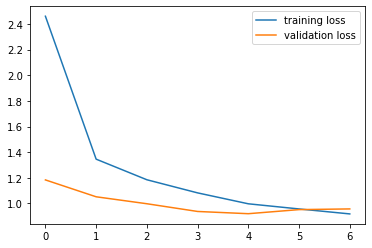

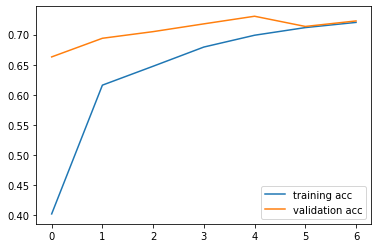

In [ ]:

print(hist.history.keys())
plt.plot(hist.history["loss"],label = "training loss")
plt.plot(hist.history["val_loss"],label = "validation loss")
plt.legend()
plt.show()
plt.figure()
plt.plot(hist.history["accuracy"],label = "training acc")
plt.plot(hist.history["val_accuracy"],label = "validation acc")
plt.legend()
plt.show()

        ResNet-50 => test accuracy : 78.33333333333333

1200


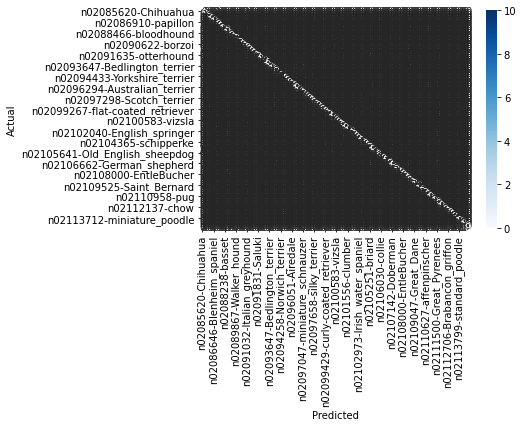

test accuracy : 78.33333333333333


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sn
import tensorflow as tf
filenames = test_generator.filenames
nb_samples = len(test_generator)
print(nb_samples)
y_pred=[]
y_act=[]
test_generator.reset()

for i in range(nb_samples):
  x_test,y_test = test_generator.next()
  y_pred.append(model.predict(x_test))
  y_act.append(y_test)

predict_class = [list(train_generator.class_indices.keys())[i.argmax()]for i in y_pred]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()]for i in y_act]
out_df = pd.DataFrame(np.vstack([predict_class,actual_class]).T,columns=['predicted_class','actual_class'])
cm = pd.crosstab(out_df['actual_class'],out_df['predicted_class'],rownames=['Actual'],colnames=['Predicted'])

sn.heatmap(cm,cmap='Blues',annot=True,fmt='d')
plt.show()
print('test accuracy : {}'.format((np.diagonal(cm).sum()/cm.sum().sum()*100)))
